## Import packages

In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

/Users/pradyumna/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
np.random.seed(23) # from random.org

In [6]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(graphics)

## Custom functions

In [8]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [9]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [10]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

## Define some parameters for the simulations


In [17]:
# Parameters for the simulations
boundary=1
error_weight=0.05
# Using median values for the parameters extracted from GLAM fit for all 33 participants (binned case, for this case)
gamma = -0.57
tau = 1.62
v = 0.000049
s = 0.00797
t0 = 0
parameters = [v , gamma, s, tau, t0]
## error_range given by the reaction time values for an individual participant
rt_min = 1500
rt_max = 5000
error_range = (rt_min, rt_max)

n_repeats = 1

# Simulations : is |DEvidence| ~ Confidence?

In the following points I will check if DEvidence (the absolute difference between the accumulators for left and right items), as calculated from GLAM, overcomes the hurdles reported in Moral et al. (2015) as typical empirical patterns observed in the choice-confidence paradigm. 

I defined different pairs of values for the two options and I kept constant the gaze ratio for left and right item (50% of time in each item) 


## 1. Negative relationship between confidence and difficulty?

### Create a matrix with controlled differences in value and in gaze ratios

In [26]:
## DEFINE PARAMETERS
# Using median values for the parameters (binned case, for now)
gamma = -0.57
tau = 1.62
v = 0.000049
s = 0.00797
t0 = 0
parameters = [v , gamma, s, tau, t0]
## error_range given by the reaction time values for an individual participant
rt_min = 1500
rt_max = 5000
error_range = (rt_min, rt_max)

n_repeats = 1

#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
# replicate the values three times to have bigger sample (remember we have a noise component that makes the results different despite the same pair)
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

# Simulate trials 
Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

In [27]:
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):    
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][0] -value_tests[i][1]))
    absDG.append(abs(gaze_tests[i][0] -gaze_tests[i][1]))

Pearson's r = 0.313 p =  0.001


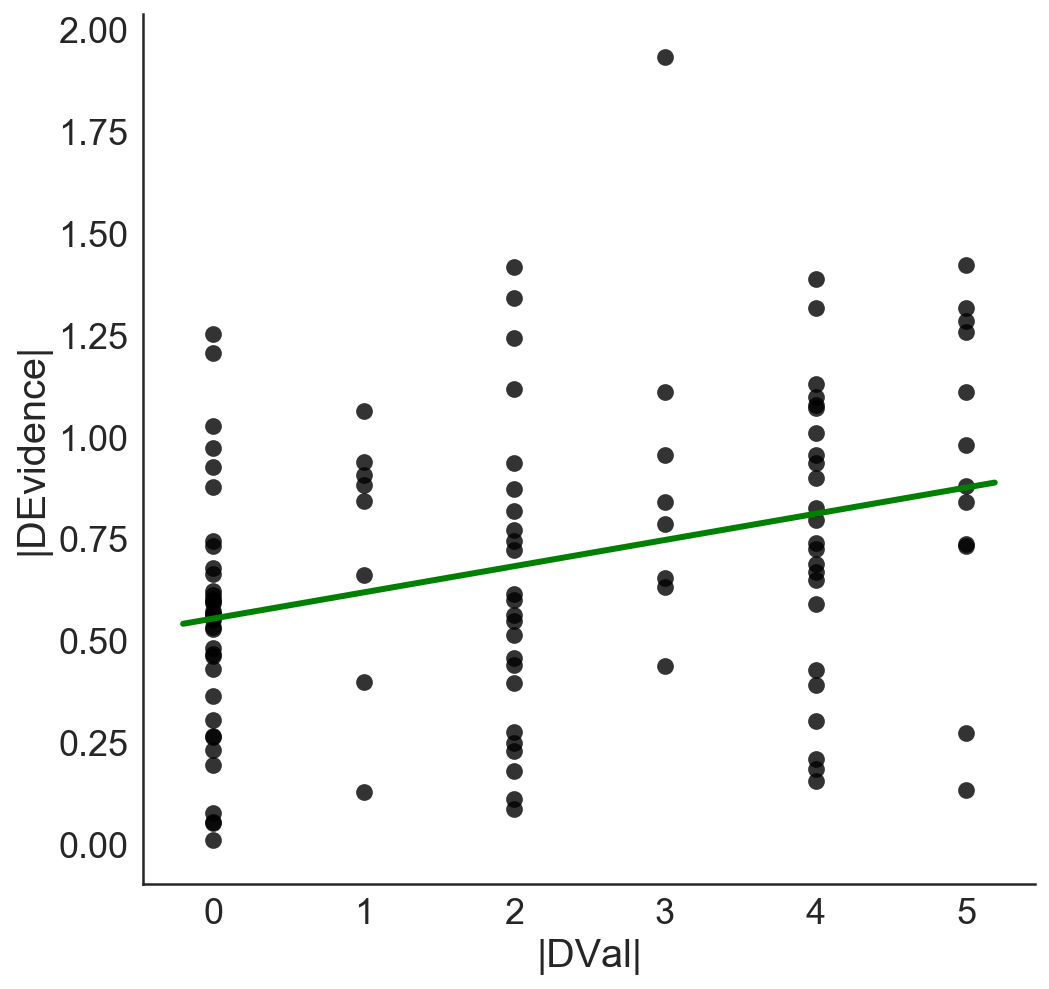

In [28]:
df = pd.DataFrame({'DVal':absDV, 'DGazw':absDG, 'RT':rts,'DEv':Dev_a})
correl_plot(df,'DVal', "|DVal|",'DEv','|DEvidence|')

The more difficult the choice (lower |DVal|) |DEvidence| decreases

## 2. Negative relationship between confidence and RT? During free response tasks

In [29]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):    
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))
 

Pearson's r = -0.217 p =  0.022


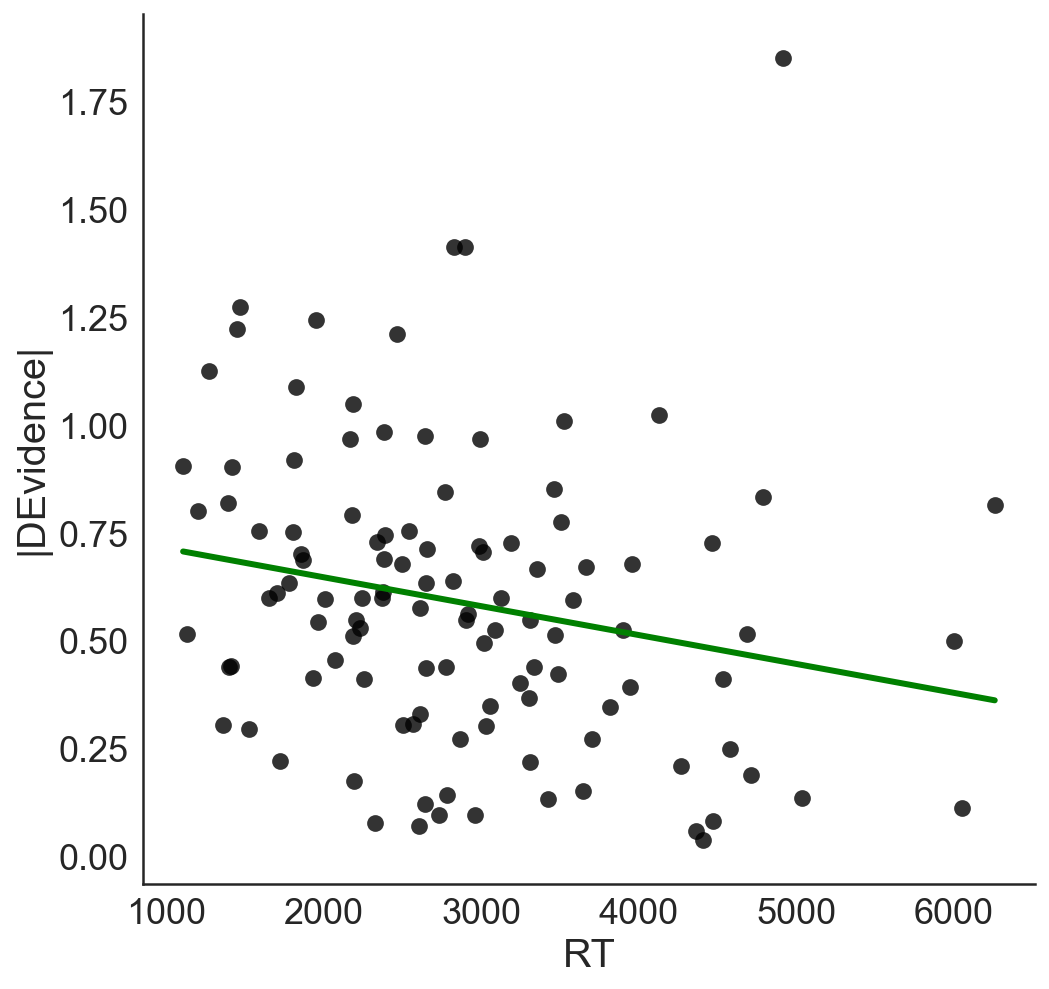

In [31]:
#Plotting   
df = pd.DataFrame({'DVal':absDV, 'DGazw':absDG, 'RT':rts,'DEv':Dev_a})
correl_plot(df,'RT', "RT",'DEv','|DEvidence|')

The faster the free response time (lower RT) higher is the |DEvidence|

## 3. Positive relationship between confidence and RT? During controlled response tasks

In [33]:
#DEFINE THE VALUES TO TEST
n_repeats = 1

value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

In [34]:
#generate vector with the reaction times (controlled) and difference in evidence.
# Since it is controlled reaction time, we consider how would it behaves if we give less time that required to answer freely, which would be before the min reaction time.
controlRT = []
controlDEv = []

for p in range(len(evi_seq_0)):
    for s in range(100,rt_min,100):
         if s<len(evi_seq_1[p][0]):
            controlDEv.append(abs(evi_seq_1[p][0][s] - evi_seq_0[p][0][s])) 
            controlRT.append(s)  

Pearson's r = 0.368 p =  0.0


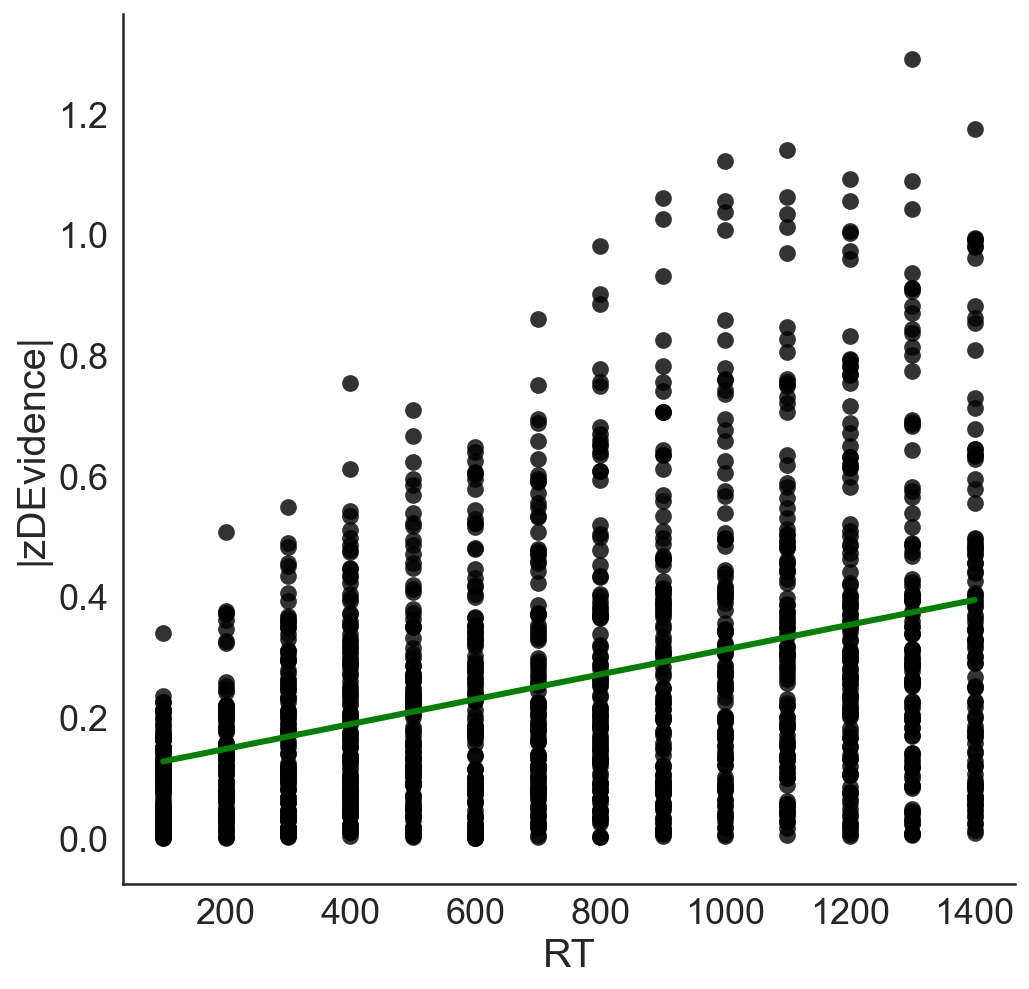

In [36]:
#Plotting   
df = pd.DataFrame({'RT':controlRT,'DEv':controlDEv})
correl_plot(df,'RT', "RT",'DEv','|zDEvidence|')

I simulated controlled response as the case when the simulation has less time than required to give a free response. Since I set a free response range of 1500-5000 [ms] I consider that controlled responses will be given before we reach the minimum time observed for free response.
We observe that |zDEvidence| increases with RT in this case

## 4. Resolution of confidence (Choice correctness and confidence are positively correlated)

We increase the number of datapoints in the following simulations (to have correct estimates of resolution of confidence)

In [37]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)

gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

correct =[]
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):
    if (choices[i] == 1 and value_tests[i][1]>value_tests[i][0]) or (choices[i] == 0 and value_tests[i][1]<value_tests[i][0]):
        correct.append(1)
    else:
        correct.append(0)
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))
 

In [46]:
#Plotting   
df = pd.DataFrame({'Correct':correct,'DEv':Dev_a,'DVal':absDV})

Pearson's r = 0.22 p =  0.001


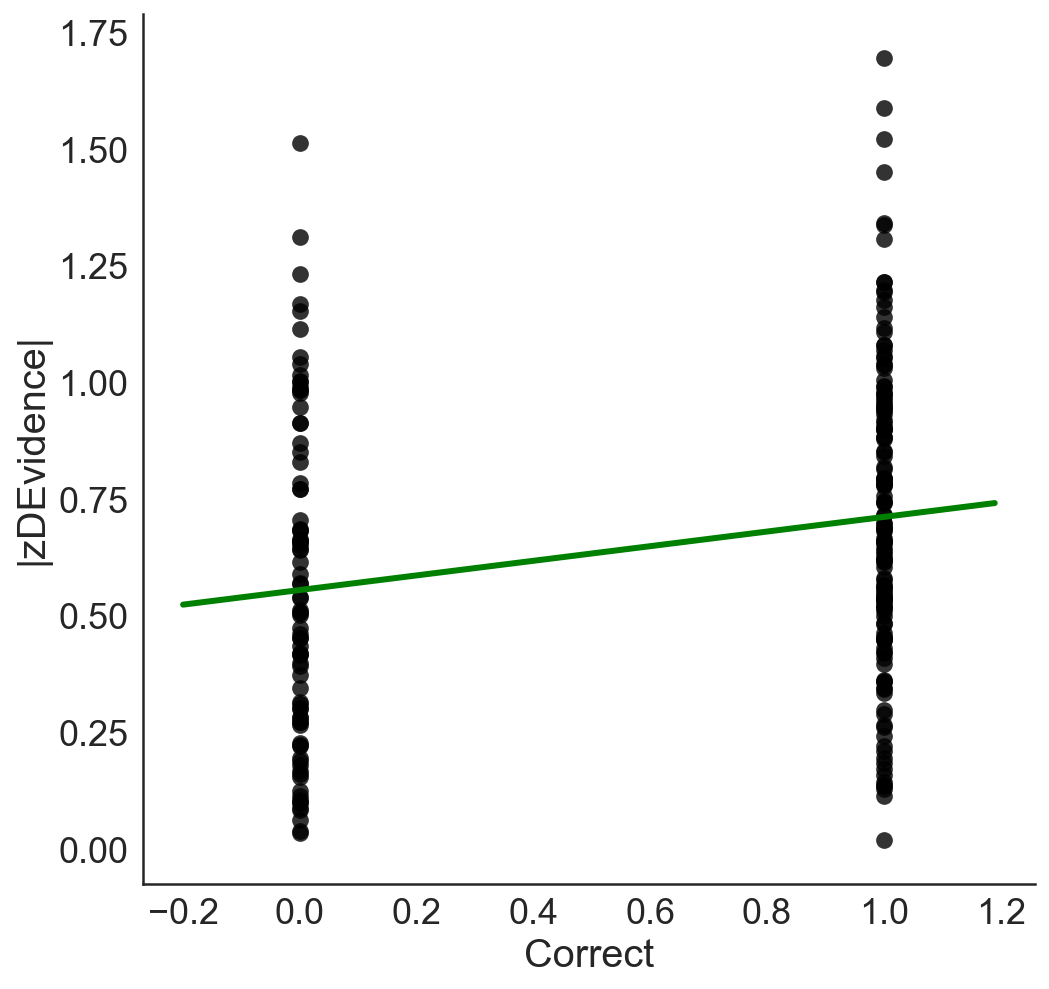

In [51]:
correl_plot(df,'Correct',"Correct",'DEv','|zDEvidence|')

In [48]:
%%R -i df
d <- df

BIC: 297.0118
Call:  glm(formula = Correct ~ DEv, family = binomial(link = "logit"), 
    data = d)

Coefficients:
(Intercept)          DEv  
    -0.3891       1.3944  

Degrees of Freedom: 223 Total (i.e. Null);  222 Residual
Null Deviance:	    297.4 
Residual Deviance: 286.2 	AIC: 290.2


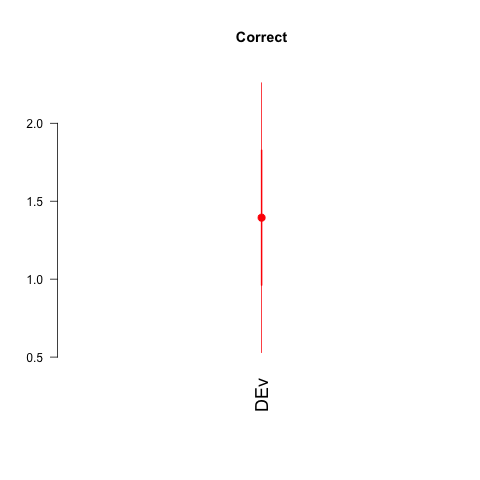

In [49]:
%%R    
title_plot = "Correct"
ModelChoice_1 <- glm(Correct ~ DEv  , data= d,family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

From linear regression, there is a positive effect of |DEVidence| over the outcome of the choice (Correct response)

## 5. Increased resolution in confidence with time pressure on choice
When choice is made under conditions that stress speed rather than accuracy, resolution of confidence increases

In [118]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)

gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

In [119]:
## generate correct vector
correct_answer =[]
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):
    if (value_tests[i][1]>value_tests[i][0]):
        correct_answer.append(1)
    else:
        correct_answer.append(0)
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))


#generate vector with the reaction times (controlled) and difference in evidence.
# Since it is controlled reaction time, we consider how would it behaves if we give less time that required to answer freely, which would be before the min reaction time.
controlRT = []
controlDEv = []
controlCorrect = []

for p in range(len(evi_seq_0)):
    for s in range(100,rt_min,50):
         if s<len(evi_seq_1[p][0]):    
            controlDEv.append(abs(evi_seq_1[p][0][s] - evi_seq_0[p][0][s])) 
            controlRT.append(s)  
            if ((evi_seq_1[p][0][s] > evi_seq_0[p][0][s]) and (correct_answer[p]==1)) or (evi_seq_1[p][0][s] < evi_seq_0[p][0][s]) and (correct_answer[p]==0) :
                    controlCorrect.append(1)    
            else:
                    controlCorrect.append(0)
            
            

Pearson's r = 0.38 p =  0.0


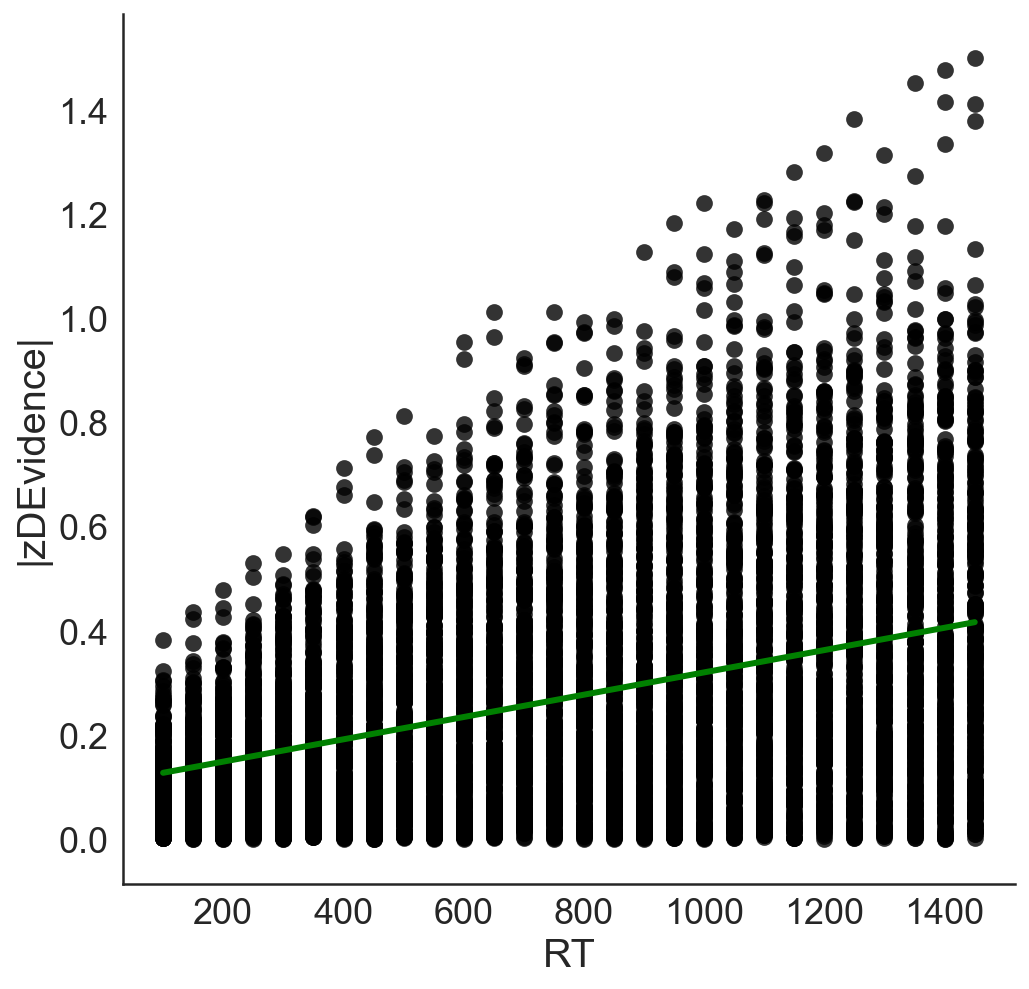

In [120]:
#Plotting   
df = pd.DataFrame({'RT':controlRT,'DEv':controlDEv,'Correct':controlCorrect})
correl_plot(df,'RT', "RT",'DEv','|zDEvidence|')

In [121]:
stressResolution = []
stressRT =[]
for s in  (df['RT'].unique()):
    stressRT.append(s)
    Selected_data = df.loc[df['RT'] == s]    
    logit = sm.Logit(Selected_data['Correct'],Selected_data['DEv'])
    result = logit.fit(disp=0)
    slope_curr = result.params.values[0]
    stressResolution.append(slope_curr)

Pearson's r = -0.478 p =  0.01


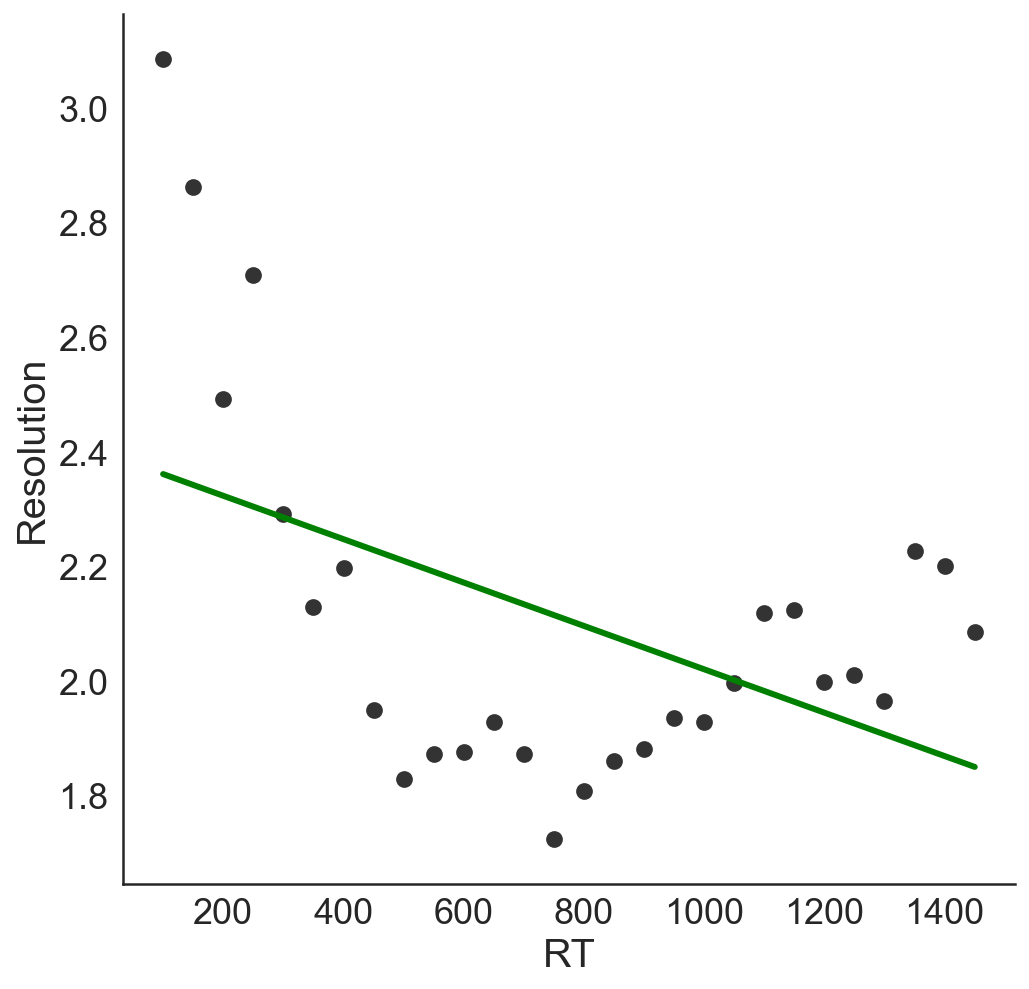

In [122]:
df2 = pd.DataFrame({'RT':stressRT,'Resolution':stressResolution})
correl_plot(df2,'RT', "RT",'Resolution','Resolution')

The more "stressed" the response (lower RT) the better the resolution (resolution measured as the slope of a logistic regression between Correct and AbsDEvidence). 

** This result seems to be less robust since it appears to dependend on the particular simulation, and sometimes is expressed only a negative trend between resolution and RT **

## 6.Difficulty and choice accuracy interaction on confidence

 "As the difficulty level increases confidence decreases for correct choices and increases for error choices. Thus, the overall resolution decreases".
 
Or alternatively, if difficulty decreases (DVal increases) confidence increases for correct choices and decreases for errors.

In [127]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)

gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

correct =[]
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):
    if (choices[i] == 1 and value_tests[i][1]>value_tests[i][0]) or (choices[i] == 0 and value_tests[i][1]<value_tests[i][0]):
        correct.append(1)
    else:
        correct.append(0)
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))
 

In [128]:
#Plotting   
df = pd.DataFrame({'Correct':correct,'DEv':Dev_a,'DVal':absDV})

In [129]:
%%R -i df
d <- df

BIC: 219.9134
Call:  glm(formula = DEv ~ Correct + Correct:DVal, data = d)

Coefficients:
 (Intercept)       Correct  Correct:DVal  
     0.49345       0.05186       0.07133  

Degrees of Freedom: 447 Total (i.e. Null);  445 Residual
Null Deviance:	    51.27 
Residual Deviance: 40.58 	AIC: 203.5


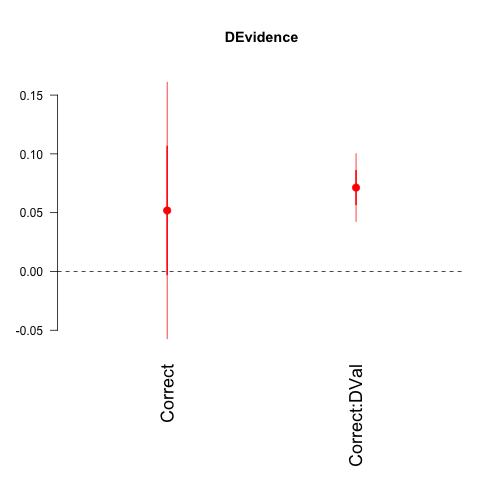

In [131]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(DEv ~ Correct  + Correct:DVal  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

We observe a positive interaction between Correct and DVal which means that when |DVal| increases (less difficulty) and we have a correct answer, confidence also increases.

## - I did not considered the hurdles related to RT2:
 RT2 correlations
 
 Difficulty and choice accuracy interaction on RT2

----------------------------------------------------------------------------------------------------------
# Simulations of DEvidence using participant's parameters and comparison with reported confidence

## Load data and GLAM structure 
Used binned data for simulation.

In [133]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [134]:
# Load data for FF2018 study 
data_all = pd.read_csv('data/FF2018_data/FFAllData_Like.csv')
data_all = data_all.drop(['Unnamed: 0'], axis=1)


## Load parameter estimates for participants

Use the parameter estimates from GLAM fit for Like, Binned data

In [135]:
sufix = '_Like_FixBin5'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
glam_full.estimates = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_part = glam_full.estimates

In [136]:
params_part

,SNR,SNR_mu,SNR_sd,b,gamma,gamma_mu,gamma_sd,p_error,s,t0,tau,tau_mu,tau_sd,v,v_mu,v_sd
0,185.37,163.26,31.44,1.0,-0.45,-0.51,0.35,0.05,0.008199,0.0,2.19,1.73,0.99,0.000044,0.000052,0.000011
1,168.78,163.26,31.44,1.0,-0.08,-0.51,0.35,0.05,0.010155,0.0,1.77,1.73,0.99,0.000063,0.000052,0.000011
2,147.59,163.26,31.44,1.0,0.38,-0.51,0.35,0.05,0.008840,0.0,2.43,1.73,0.99,0.000056,0.000052,0.000011
3,169.79,163.26,31.44,1.0,-0.59,-0.51,0.35,0.05,0.006967,0.0,2.40,1.73,0.99,0.000041,0.000052,0.000011
4,102.31,163.26,31.44,1.0,-0.61,-0.51,0.35,0.05,0.007075,0.0,3.88,1.73,0.99,0.000066,0.000052,0.000011
5,125.34,163.26,31.44,1.0,-0.29,-0.51,0.35,0.05,0.008380,0.0,0.33,1.73,0.99,0.000062,0.000052,0.000011
6,160.60,163.26,31.44,1.0,-0.63,-0.51,0.35,0.05,0.011196,0.0,0.82,1.73,0.99,0.000067,0.000052,0.000011
7,171.68,163.26,31.44,1.0,-0.48,-0.51,0.35,0.05,0.007631,0.0,1.39,1.73,0.99,0.000043,0.000052,0.000011
8,197.25,163.26,31.44,1.0,-0.97,-0.51,0.35,0.05,0.010153,0.0,1.06,1.73,0.99,0.000054,0.000052,0.000011
9,185.06,163.26,31.44,1.0,-0.48,-0.51,0.35,0.05,0.009120,0.0,1.73,1.73,0.99,0.000044,0.000052,0.000011


## Run drift simulations for selected values and parameters

In [144]:
n_repeats = 2

In [145]:
# We will assume that every single pair in test will have a gaze_test pair assigned. Therefore
# len(value_tests) = len(gaze_tests) 
      
# Using median participant parameters for testing drift

# repeat for all the 'i' participants
#

AbsDEvid = []

#for i in ([0, 1, 2, 3]):    
for i in (data['subject'].unique()):    
    PartData = data.loc[data['subject'] == i]
    value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
    gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

    gamma = params_part['gamma'][i]
    tau = params_part['tau'][i]
    v = params_part['v'][i]
    s = params_part['s'][i]
    t0 = 0
    parameters = [v , gamma, s, tau, t0]
    ## error_range given by the reaction time values for an individual participant
    rt_min = glam_full.data['rt'][glam_full.data['subject'] == i].values.min()
    rt_max = glam_full.data['rt'][glam_full.data['subject'] == i].values.max()
    error_range = (rt_min, rt_max)

    Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

    for  j in range(len(Dev_a)):    
        AbsDEvid.append(Dev_a[j])
    print ("subj " + str(i))
    

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30
subj 31
subj 32


In [146]:
data_all["AbsDEv"] = AbsDEvid

## Calculate z-score and correlation between DEvidence and Confidence

In [155]:
zs1 = z_score1(data_all,'Part','AbsDEv')
data_all["zAbsDEv"] = zs1

Pearson's r = 0.06 p =  0.0


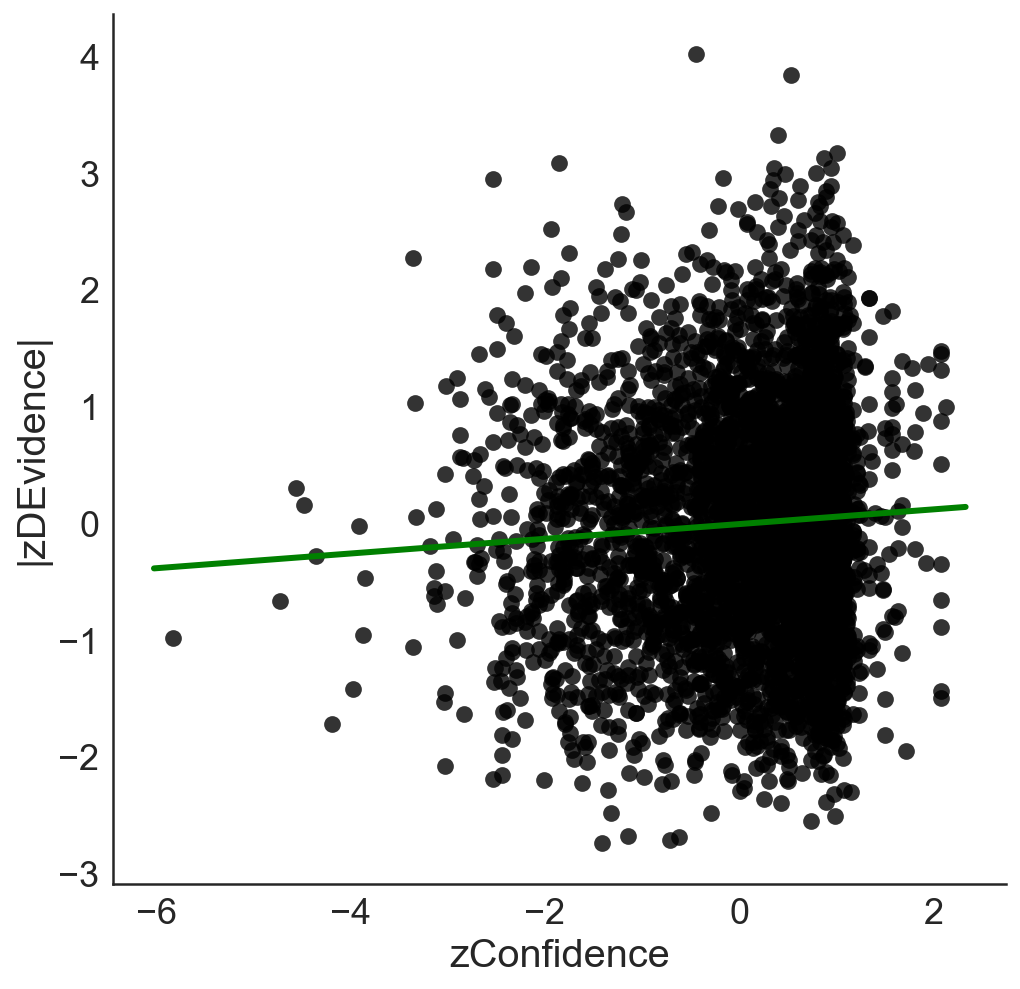

In [156]:
correl_plot(data_all,'zConf', "zConfidence",'zAbsDEv','|zDEvidence|')

* We z-scored the absolute values, that's why we obtain |zDEvidence| include some negative values

In [157]:
%%R -i data_all
d <- data_all

BIC: 10858.78
Call:  glm(formula = zConf ~ zAbsDEv, data = d)

Coefficients:
(Intercept)      zAbsDEv  
    0.09837      0.05713  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    3589 
Residual Deviance: 3576 	AIC: 10840


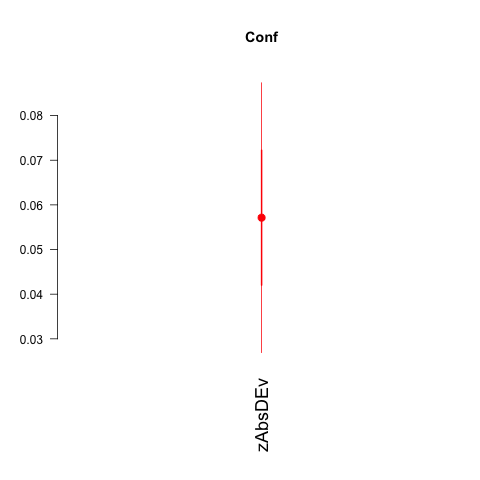

In [158]:
%%R    
title_plot = "Conf"
ModelChoice_1 <- glm(zConf ~ zAbsDEv  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

## [END]